# Crime Rate Regression

Based on: MCPP & Season


In [ ]:
#data preprocessing and CV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold, cross_validate
#from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OrdinalEncoder

#data imbalance handling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

# Can use either of the three classifiers below
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Lasso, RidgeCV, LogisticRegression, LassoCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn import ensemble #import all ensemble model

#from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, confusion_matrix, classification_report

## Model Input Preprocessing

RF regressor on CRIME_RATE

In [ ]:
#load data (this df already combined the crime data aggregated per year and season, and mcpp population demographic)
crime_census_df = pd.read_csv("./crime_census_df_2010-2019_CR_SEASON.csv",
                        index_col= [0]) #csv contains index

In [ ]:
#recheck model input
crime_census_df.tail()

,MCPP,SEASON,YEAR,OFFENSE_COUNT,MCPP_POPULATION,MCPP_ACRES_LAND,MCPP_MEDIAN_AGE,MCPP_PCT_OCCUPIED_HOUSING,MCPP_PCT_BACHELOR,MCPP_MEDIAN_GROSS_RENT,MCPP_PCT_UNEMPLOYED,MCPP_MEDIAN_HH_INCOME,MCPP_PCT_POVERTY,CRIME_RATE
2315,WALLINGFORD,Winter,2015,244,15785.0,902.37,34.58,45.77,71.02,1104.4,5.54,71316.1,13.37,15.46
2316,WALLINGFORD,Winter,2016,330,15785.0,902.37,34.58,45.77,71.02,1104.4,5.54,71316.1,13.37,20.91
2317,WALLINGFORD,Winter,2017,336,15785.0,902.37,34.58,45.77,71.02,1104.4,5.54,71316.1,13.37,21.29
2318,WALLINGFORD,Winter,2018,300,15785.0,902.37,34.58,45.77,71.02,1104.4,5.54,71316.1,13.37,19.01
2319,WALLINGFORD,Winter,2019,227,15785.0,902.37,34.58,45.77,71.02,1104.4,5.54,71316.1,13.37,14.38


### Encode Categorical

In [ ]:
input_df = crime_census_df.copy()

from sklearn.compose import make_column_selector as selector

cat_col_selector = selector(dtype_include= object)
cat_cols = cat_col_selector(input_df)
cat_cols

['MCPP', 'SEASON']

In [ ]:
enc = OrdinalEncoder()
input_df[cat_cols] = enc.fit_transform(input_df[cat_cols])
input_df.head()

,MCPP,SEASON,YEAR,OFFENSE_COUNT,MCPP_POPULATION,MCPP_ACRES_LAND,MCPP_MEDIAN_AGE,MCPP_PCT_OCCUPIED_HOUSING,MCPP_PCT_BACHELOR,MCPP_MEDIAN_GROSS_RENT,MCPP_PCT_UNEMPLOYED,MCPP_MEDIAN_HH_INCOME,MCPP_PCT_POVERTY,CRIME_RATE
0,0.0,0.0,2010,203,10805.0,871.16,38.03,56.23,52.69,1004.43,6.99,67934.71,11.51,18.79
1,0.0,0.0,2011,149,10805.0,871.16,38.03,56.23,52.69,1004.43,6.99,67934.71,11.51,13.79
2,0.0,0.0,2012,209,10805.0,871.16,38.03,56.23,52.69,1004.43,6.99,67934.71,11.51,19.34
3,0.0,0.0,2013,213,10805.0,871.16,38.03,56.23,52.69,1004.43,6.99,67934.71,11.51,19.71
4,0.0,0.0,2014,155,10805.0,871.16,38.03,56.23,52.69,1004.43,6.99,67934.71,11.51,14.35


In [ ]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MCPP                       232 non-null    float64
 1   SEASON                     232 non-null    float64
 2   OFFENSE_COUNT              232 non-null    int64  
 3   MCPP_POPULATION            232 non-null    float64
 4   MCPP_ACRES_LAND            232 non-null    float64
 5   MCPP_MEDIAN_AGE            232 non-null    float64
 6   MCPP_PCT_OCCUPIED_HOUSING  232 non-null    float64
 7   MCPP_PCT_BACHELOR          232 non-null    float64
 8   MCPP_MEDIAN_GROSS_RENT     232 non-null    float64
 9   MCPP_PCT_UNEMPLOYED        232 non-null    float64
 10  MCPP_MEDIAN_HH_INCOME      232 non-null    float64
 11  MCPP_PCT_POVERTY           232 non-null    float64
 12  CRIME_RATE                 232 non-null    float64
dtypes: float64(12), int64(1)
memory usage: 23.7 KB


In [ ]:
#check categories for the categorical columns.
enc.categories_

[array(['ALASKA JUNCTION', 'ALKI', 'BALLARD NORTH', 'BALLARD SOUTH',
        'BELLTOWN', 'BITTERLAKE', 'BRIGHTON/DUNLAP', 'CAPITOL HILL',
        'CENTRAL AREA/SQUIRE PARK', 'CHINATOWN/INTERNATIONAL DISTRICT',
        'CLAREMONT/RAINIER VISTA', 'COLUMBIA CITY', 'COMMERCIAL DUWAMISH',
        'COMMERCIAL HARBOR ISLAND', 'DOWNTOWN COMMERCIAL',
        'EASTLAKE - EAST', 'EASTLAKE - WEST', 'FAUNTLEROY SW',
        'FIRST HILL', 'FREMONT', 'GENESEE', 'GEORGETOWN', 'GREENWOOD',
        'HIGH POINT', 'HIGHLAND PARK', 'HILLMAN CITY',
        'JUDKINS PARK/NORTH BEACON HILL', 'LAKECITY',
        'LAKEWOOD/SEWARD PARK', 'MADISON PARK', 'MADRONA/LESCHI',
        'MAGNOLIA', 'MID BEACON HILL', 'MILLER PARK',
        'MONTLAKE/PORTAGE BAY', 'MORGAN', 'MOUNT BAKER', 'NEW HOLLY',
        'NORTH ADMIRAL', 'NORTH BEACON HILL', 'NORTH DELRIDGE',
        'NORTHGATE', 'PHINNEY RIDGE', 'PIGEON POINT', 'PIONEER SQUARE',
        'QUEEN ANNE', 'RAINIER BEACH', 'RAINIER VIEW', 'ROOSEVELT/RAVENNA',
        'RO

In [ ]:
enc.categories_[1]

array(['Fall', 'Spring', 'Summer', 'Winter'], dtype=object)

In [ ]:
input_df['SEASON'].unique()

array([0., 1., 2., 3.])

### Split Train Test

In [ ]:
#set features X and target y variables
# Treat the column CRIME_RATE as our predictive objective
y = input_df["CRIME_RATE"]

# All other columns will be used as features when training our model
X = input_df.drop(["CRIME_RATE", "OFFENSE_COUNT", "YEAR"], axis=1)

print("Shape of X:",X.shape)
print("Shape of Y:",y.shape)

Shape of X: (2320, 11)
Shape of Y: (2320,)


In [ ]:
# Split 70% of the data for training and leave out 30% for testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, random_state=42,
                                                    stratify=X['MCPP']) #only for finer time features but left it here

print("Shape of X_train:",X_train.shape)
print("Shape of X_test:",X_test.shape)

Shape of X_train: (1624, 11)
Shape of X_test: (696, 11)


In [ ]:
X_test.head()

,MCPP,SEASON,MCPP_POPULATION,MCPP_ACRES_LAND,MCPP_MEDIAN_AGE,MCPP_PCT_OCCUPIED_HOUSING,MCPP_PCT_BACHELOR,MCPP_MEDIAN_GROSS_RENT,MCPP_PCT_UNEMPLOYED,MCPP_MEDIAN_HH_INCOME,MCPP_PCT_POVERTY
714,17.0,3.0,6209.0,789.03,40.60,73.20,45.32,1184.20,5.32,79931.60,7.72
1745,43.0,2.0,711.0,225.36,35.55,65.35,41.00,1268.00,8.60,68758.00,8.00
1444,36.0,0.0,6446.0,693.64,40.75,55.00,41.08,669.75,6.12,55618.00,15.73
204,5.0,0.0,17081.0,1786.49,40.74,59.39,43.91,1002.40,7.57,60645.70,12.17
1823,45.0,2.0,36037.0,2137.67,34.98,38.06,66.75,1061.75,5.03,65402.83,9.28


## Linear Regression

### Linear ALL data (baseline)

In [ ]:
#Train the model: linear regression
    #default optimizer is Batch Gradient Descent (unchanged)
    #default hyperparameter: max_iter=1000, tol=1e-4, alpha=1.0 (changed alpha)

#record the time
import time
start_time = time.time()

reg_linear = LinearRegression() #based on grid search cv below
reg_linear.fit(X_train, y_train)
print("Linear model cofficients :", reg_linear.coef_)
print("--- %s seconds ---" % (time.time() - start_time))

Linear model cofficients : [ 4.31910337e-01 -4.38548081e-01 -1.27173484e-03  1.11750762e-02
  6.60563035e+00 -9.06332930e-01  4.66136199e-01  9.49520978e-02
 -1.33877489e+00 -1.96760467e-03  4.28937708e-01]
--- 0.009720087051391602 seconds ---


In [ ]:
#predict

#record the time
import time
start_time = time.time()

y_pred_linear_tr = reg_linear.predict(X_train)
y_pred_linear = reg_linear.predict(X_test)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.001615285873413086 seconds ---


In [ ]:
#test data performance metrics

#RMSE (squared=False returns rmse)
rmse_linear_tr = round(mean_squared_error(y_train, y_pred_linear_tr, squared=False),4)
rmse_linear = round(mean_squared_error(y_test, y_pred_linear, squared=False),4)

#R2
r2_linear_tr = round(r2_score(y_train, y_pred_linear_tr), 4)
r2_linear = round(r2_score(y_test, y_pred_linear), 4)

print('linear Regression (ALL) training data - Root Mean Squared Error (RMSE):', rmse_linear_tr)
print('linear Regression (ALL) test data - Root Mean Squared Error (RMSE):', rmse_linear)

print('linear Regression (ALL) train data - R-Squared:', r2_linear_tr)
print('linear Regression (ALL) test data - R-Squared:', r2_linear)

linear Regression (ALL) training data - Root Mean Squared Error (RMSE): 26.4161
linear Regression (ALL) test data - Root Mean Squared Error (RMSE): 28.2948
linear Regression (ALL) train data - R-Squared: 0.6361
linear Regression (ALL) test data - R-Squared: 0.6199


Result for OLS:

* linear Regression (ALL) training data - Root Mean Squared Error (RMSE): 26.4161
* linear Regression (ALL) test data - Root Mean Squared Error (RMSE): 28.2948
* linear Regression (ALL) train data - R-Squared: 0.6361
* linear Regression (ALL) test data - R-Squared: 0.6199


Result Lasso(max_iter=200, tol=0.001), below. Very similar.:

* Lasso Regression (ALL) training data - Root Mean Squared Error (RMSE): 26.4414
* Lasso Regression (ALL) test data - Root Mean Squared Error (RMSE): 28.3675
* Lasso Regression (ALL) train data - R-Squared: 0.6354
* Lasso Regression (ALL) test data - R-Squared: 0.618



**analysis:** basically lineaar regression is good?

but RMSE is quite high!

In [ ]:
linearFeatures_reg = pd.DataFrame({'FeatureNames': reg_linear.feature_names_in_,
                            'Coefficient': reg_linear.coef_},
                           columns=['FeatureNames', 'Coefficient'])
linearFeatures_reg = linearFeatures_reg.sort_values(by=['Coefficient'], ascending=False)
linearFeatures_reg

,FeatureNames,Coefficient
4,MCPP_MEDIAN_AGE,6.605630
6,MCPP_PCT_BACHELOR,0.466136
0,MCPP,0.431910
10,MCPP_PCT_POVERTY,0.428938
7,MCPP_MEDIAN_GROSS_RENT,0.094952
3,MCPP_ACRES_LAND,0.011175
2,MCPP_POPULATION,-0.001272
9,MCPP_MEDIAN_HH_INCOME,-0.001968
1,SEASON,-0.438548
5,MCPP_PCT_OCCUPIED_HOUSING,-0.906333


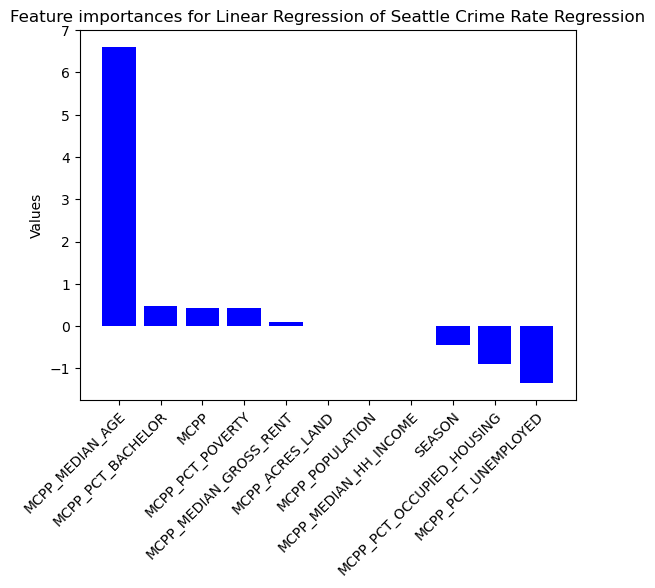

In [ ]:
plt.bar(x=linearFeatures_reg['FeatureNames'],
        height=linearFeatures_reg['Coefficient'],
        color='blue')
plt.title('Feature importances for Linear Regression of Seattle Crime Rate Regression')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.ylabel('Values')
plt.show()

#### Linear conclusion

* lower max iter is better
* coefficient value represent feature importance as the higher the weight, the more relationship of features with the target
* Median age has highest importance on the modeling
* this is the base model, so no optimization is done

## Lasso Regression

### Lasso ALL data

In [ ]:
#Train the model: lasso regression
    #default optimizer is Batch Gradient Descent (unchanged)
    #default hyperparameter: max_iter=1000, tol=1e-4, alpha=1.0 (changed alpha)

#record the time
import time
start_time = time.time()

reg_lasso = Lasso(max_iter=200, tol=0.001) #based on grid search cv below
reg_lasso.fit(X_train, y_train)
print("Lasso model cofficients :", reg_lasso.coef_)
print("--- %s seconds ---" % (time.time() - start_time))

Lasso model cofficients : [ 4.26232296e-01 -0.00000000e+00 -1.24857319e-03  1.10126933e-02
  6.56263272e+00 -9.64351340e-01  5.03029141e-01  8.83497279e-02
 -0.00000000e+00 -1.86827871e-03  2.18061527e-01]
--- 0.006044149398803711 seconds ---


In [ ]:
#predict

#record the time
import time
start_time = time.time()

y_pred_lasso_tr = reg_lasso.predict(X_train)
y_pred_lasso = reg_lasso.predict(X_test)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0 seconds ---


In [ ]:
#test data performance metrics

#RMSE (squared=False returns rmse)
rmse_lasso_tr = round(mean_squared_error(y_train, y_pred_lasso_tr, squared=False),4)
rmse_lasso = round(mean_squared_error(y_test, y_pred_lasso, squared=False),4)

#R2
r2_lasso_tr = round(r2_score(y_train, y_pred_lasso_tr), 4)
r2_lasso = round(r2_score(y_test, y_pred_lasso), 4)

print('Lasso Regression (ALL) training data - Root Mean Squared Error (RMSE):', rmse_lasso_tr)
print('Lasso Regression (ALL) test data - Root Mean Squared Error (RMSE):', rmse_lasso)

print('Lasso Regression (ALL) train data - R-Squared:', r2_lasso_tr)
print('Lasso Regression (ALL) test data - R-Squared:', r2_lasso)

Lasso Regression (ALL) training data - Root Mean Squared Error (RMSE): 26.4414
Lasso Regression (ALL) test data - Root Mean Squared Error (RMSE): 28.3675
Lasso Regression (ALL) train data - R-Squared: 0.6354
Lasso Regression (ALL) test data - R-Squared: 0.618


Result for alpha=0.001:

* Lasso Regression (ALL) test data - Root Mean Squared Error (RMSE): 256.998
* Lasso Regression (ALL) test data - R-Squared: 0.6248


Result Lasso(max_iter=200, tol=0.001):

* Lasso Regression (ALL) training data - Root Mean Squared Error (RMSE): 26.4414
* Lasso Regression (ALL) test data - Root Mean Squared Error (RMSE): 28.3675
* Lasso Regression (ALL) train data - R-Squared: 0.6354
* Lasso Regression (ALL) test data - R-Squared: 0.618



**analysis:** basically lineaar regression is good?

but RMSE is quite high!

In [ ]:
lassoFeatures_reg = pd.DataFrame({'FeatureNames': reg_lasso.feature_names_in_,
                            'Coefficient': reg_lasso.coef_},
                           columns=['FeatureNames', 'Coefficient'])
lassoFeatures_reg = lassoFeatures_reg.sort_values(by=['Coefficient'], ascending=False)
lassoFeatures_reg

,FeatureNames,Coefficient
4,MCPP_MEDIAN_AGE,6.562633
6,MCPP_PCT_BACHELOR,0.503029
0,MCPP,0.426232
10,MCPP_PCT_POVERTY,0.218062
7,MCPP_MEDIAN_GROSS_RENT,0.088350
3,MCPP_ACRES_LAND,0.011013
1,SEASON,-0.000000
8,MCPP_PCT_UNEMPLOYED,-0.000000
2,MCPP_POPULATION,-0.001249
9,MCPP_MEDIAN_HH_INCOME,-0.001868


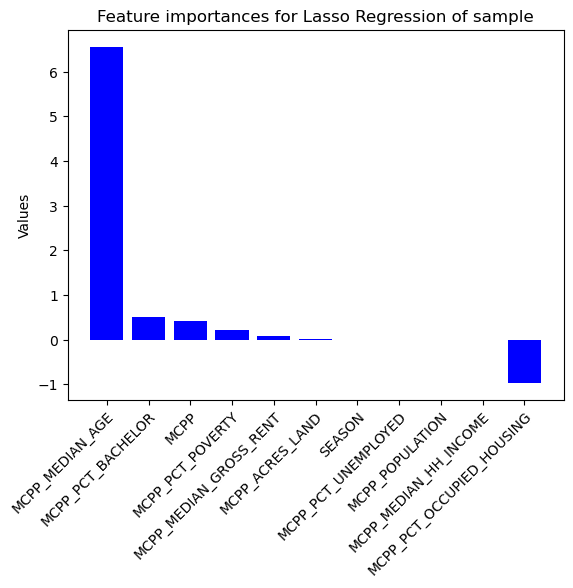

In [ ]:
plt.bar(x=lassoFeatures_reg['FeatureNames'],
        height=lassoFeatures_reg['Coefficient'],
        color='blue')
plt.title('Feature importances for Lasso Regression of sample')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.ylabel('Values')
plt.show()

### GridSearchCV

In [ ]:
# List parameter grid
# base param: alpha=1.0, *, fit_intercept=True, precompute=False, copy_X=True, max_iter=1000, tol=0.0001,

param_grid_lasso = {
    'alpha': [0.1, 0.5, 1.0],
    'max_iter': [200, 500, 1000],
    'tol': [0.0001, 0.0005, 0.001]
}

# Create a based model
reg_lasso = Lasso()
lasso_gridCV = GridSearchCV(estimator = reg_lasso, param_grid = param_grid_lasso,
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
#record the time
import time
start_time = time.time()

#fit Grid Search
lasso_gridCV.fit(X_train, y_train)
lasso_gridCV.best_params_

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
--- 1.7090063095092773 seconds ---


In [ ]:
lasso_gridCV.best_params_

{'alpha': 1.0, 'max_iter': 200, 'tol': 0.001}

In [ ]:
lasso_gridCV.best_estimator_

Lasso(max_iter=200, tol=0.001)

ENTER THIS TO LASSO ALL DATA ABOVE

#### Lasso conclusion

* lower max iter is better
* coefficient value represent feature importance as the higher the weight, the more relationship of features with the target
* Median age has highest importance on the modeling

## Random Forest (RF)

### RF ALL data (Base model)

In [ ]:
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn import ensemble
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
#using regular model
reg_rf = ensemble.RandomForestRegressor(random_state=42)

In [ ]:
#record the time
import time
start_time = time.time()

reg_rf.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.37845492362976074 seconds ---


In [ ]:
y_pred_tr_reg = reg_rf.predict(X_train)
y_pred_reg = reg_rf.predict(X_test)

#### Performance matrices

In [ ]:
#get performance metrics for train dataset
#RMSE (squared=False returns rmse)
rmse_rf_tr_reg = round(mean_squared_error(y_train, y_pred_tr_reg, squared=False),4)

#get performance metrics for test dataset
rmse_rf_reg = round(mean_squared_error(y_test, y_pred_reg, squared=False),4)

print('Random Forest, ALL data, Crime Rate regression, RMSE train:', rmse_rf_tr_reg)
print('Random Forest, ALL data, Crime Rate regression, RMSE train:', rmse_rf_reg)

#check R2
r2_rf_tr_reg = round(r2_score(y_train, y_pred_tr_reg), 4)
r2_rf_reg = round(r2_score(y_test, y_pred_reg),4)

print('RF - ALL data, Crime Rate regression , train Rsquared:', r2_rf_tr_reg)
print("RF- ALL data, Crime Rate regression, test Rsquared: %.4f" % r2_rf_reg)

Random Forest, ALL data, Crime Rate regression, RMSE train: 9.6519
Random Forest, ALL data, Crime Rate regression, RMSE train: 12.0119
RF - ALL data, Crime Rate regression , train Rsquared: 0.9514
RF- ALL data, Crime Rate regression, test Rsquared: 0.9315


In [ ]:
crime_census_df["CRIME_RATE"].max()

401.85

In [ ]:
crime_census_df["CRIME_RATE"].min()

0.77

In [ ]:
rf_features_reg = pd.DataFrame({'FeatureNames': reg_rf.feature_names_in_,
                            'Value': reg_rf.feature_importances_},
                           columns=['FeatureNames', 'Value'])
rf_features_reg = rf_features_reg.sort_values(by=['Value'], ascending=False)
rf_features_reg

,FeatureNames,Value
4,MCPP_MEDIAN_AGE,0.587114
5,MCPP_PCT_OCCUPIED_HOUSING,0.248515
8,MCPP_PCT_UNEMPLOYED,0.035183
3,MCPP_ACRES_LAND,0.025512
6,MCPP_PCT_BACHELOR,0.022175
9,MCPP_MEDIAN_HH_INCOME,0.021276
10,MCPP_PCT_POVERTY,0.021004
1,SEASON,0.013410
2,MCPP_POPULATION,0.012070
7,MCPP_MEDIAN_GROSS_RENT,0.007975


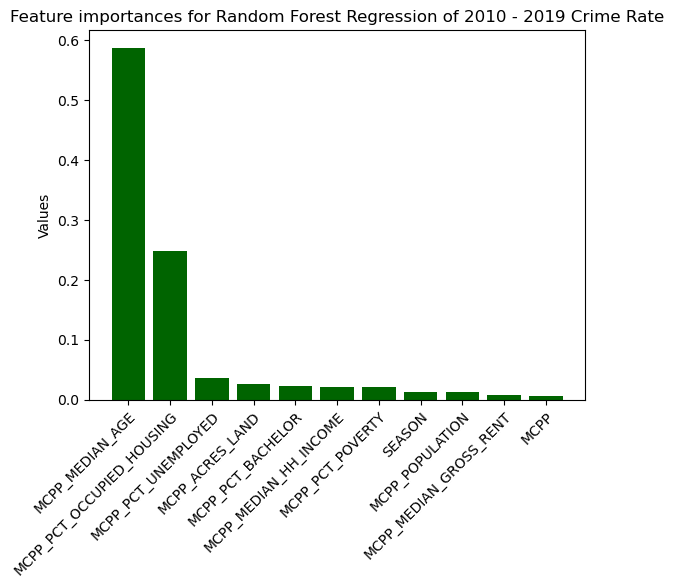

In [ ]:
plt.bar(x=rf_features_reg['FeatureNames'],
        height=rf_features_reg['Value'],
        color='darkgreen')
plt.title('Feature importances for Random Forest Regression of 2010 - 2019 Crime Rate')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.ylabel('Values')
plt.show()

In [ ]:
#compare with Lasso
lassoFeatures_reg.reset_index()

,index,FeatureNames,Coefficient
0,4,MCPP_MEDIAN_AGE,6.562633
1,6,MCPP_PCT_BACHELOR,0.503029
2,0,MCPP,0.426232
3,10,MCPP_PCT_POVERTY,0.218062
4,7,MCPP_MEDIAN_GROSS_RENT,0.088350
5,3,MCPP_ACRES_LAND,0.011013
6,1,SEASON,-0.000000
7,8,MCPP_PCT_UNEMPLOYED,-0.000000
8,2,MCPP_POPULATION,-0.001249
9,9,MCPP_MEDIAN_HH_INCOME,-0.001868


**ANALYSIS:**

median age is still the main features for predict crime rate, followed by bachelor and mcpp

MCPP has higher importance here~!

We can drop some variables to reduce the data size, based on Lasso and RF, common bottom features are:
* PCT_BACHELOR, PCT_OWNER_OCC_HOUSING, NO_HOUSEHOLD, PCT_UNEMPLOYED
* Already dropped for this regression


### GridsearchCV

RandCV parameters (not included here):

{'n_estimators': 50,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_features': 1,
 'max_depth': 36,
 'bootstrap': False}

 RandCV listed parameter:

 {'n_estimators': [50, 200, 350, 500],
 'max_features': [1, 2, 3],
 'max_depth': [5, 36, 68, 100, None],
 'min_samples_split': [3, 6, 10],
 'min_samples_leaf': [3, 5, 10],
 'bootstrap': [True, False]}

Narrow the search with GridSearchCV (run all possibility)

In [ ]:
# List parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [30, 36, 45],
    'max_features': [1, 2],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [8, 10, 13],
    'n_estimators': [30, 40, 50, 65]
}

# Create a based model
reg_rf = ensemble.RandomForestRegressor()# Instantiate the grid search model
rf_gridCV = GridSearchCV(estimator = reg_rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)
param_grid

{'bootstrap': [True, False],
 'max_depth': [30, 36, 45],
 'max_features': [1, 2],
 'min_samples_leaf': [2, 3, 4],
 'min_samples_split': [8, 10, 13],
 'n_estimators': [30, 40, 50, 65]}

In [ ]:
#record the time
import time
start_time = time.time()

# Fit the grid search
rf_gridCV.fit(X_train, y_train)

rf_gridCV.best_params_

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
--- 8.767638683319092 seconds ---


In [ ]:
rf_gridCV.best_params_

{'bootstrap': False,
 'max_depth': 45,
 'max_features': 1,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 40}

In [ ]:
rf_gridCV.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=45, max_features=1,
                      min_samples_leaf=4, min_samples_split=8, n_estimators=40)

First run:

RandomForestRegressor(max_depth=30, max_features=3, min_samples_leaf=2,
                      min_samples_split=8, n_estimators=30)
                      

In [ ]:
#compare with randomCV
rf_randCV.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=36, max_features=1,
                      min_samples_leaf=3, min_samples_split=10,
                      n_estimators=50)

#### Best GridSearch CV model on full dataset

In [ ]:
#record the time
import time
start_time = time.time()

best_gridCV = ensemble.RandomForestRegressor(**rf_gridCV.best_params_,
                                             random_state=42)

best_gridCV.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.04703879356384277 seconds ---


In [ ]:
y_pred_tr_reg_gcv = best_gridCV.predict(X_train)
y_pred_reg_gcv = best_gridCV.predict(X_test)

In [ ]:
#get performance metrics for train dataset
#RMSE (squared=False returns rmse)
rmse_rf_tr_reg_gcv = round(mean_squared_error(y_train, y_pred_tr_reg_gcv, squared=False),4)

#get performance metrics for test dataset
rmse_rf_reg_gcv = round(mean_squared_error(y_test, y_pred_reg_gcv, squared=False),4)

print('RF - best GridSearchCV param, Crime Rate regression, RMSE train:', rmse_rf_tr_reg_gcv)
print('RF - best GridSearchCV param, Crime Rate regression, RMSE train:', rmse_rf_reg_gcv)

#check R2
r2_rf_tr_reg_gcv = round(r2_score(y_train, y_pred_tr_reg_gcv), 4)
r2_rf_reg_gcv = round(r2_score(y_test, y_pred_reg_gcv),4)

print('RF - best GridSearchCV param (14 features), train R2:', r2_rf_tr_reg_gcv)
print("RF - best GridSearchCV param (14 features), test R2: %.4f" % r2_rf_reg_gcv)

RF - best GridSearchCV param, Crime Rate regression, RMSE train: 9.6781
RF - best GridSearchCV param, Crime Rate regression, RMSE train: 11.8796
RF - best GridSearchCV param (14 features), train R2: 0.9512
RF - best GridSearchCV param (14 features), test R2: 0.9330


In [ ]:
crime_census_df["CRIME_RATE"].max()

401.85

In [ ]:
crime_census_df["CRIME_RATE"].min()

0.77

In [ ]:
rf_features_reg_gcv = pd.DataFrame({'FeatureNames': best_gridCV.feature_names_in_,
                            'Value': best_gridCV.feature_importances_},
                           columns=['FeatureNames', 'Value'])
rf_features_reg_gcv = rf_features_reg_gcv.sort_values(by=['Value'], ascending=False)
rf_features_reg_gcv

,FeatureNames,Value
4,MCPP_MEDIAN_AGE,0.198707
10,MCPP_PCT_POVERTY,0.138908
9,MCPP_MEDIAN_HH_INCOME,0.108392
7,MCPP_MEDIAN_GROSS_RENT,0.091105
6,MCPP_PCT_BACHELOR,0.084762
5,MCPP_PCT_OCCUPIED_HOUSING,0.083042
3,MCPP_ACRES_LAND,0.079160
0,MCPP,0.073994
8,MCPP_PCT_UNEMPLOYED,0.073848
2,MCPP_POPULATION,0.056155


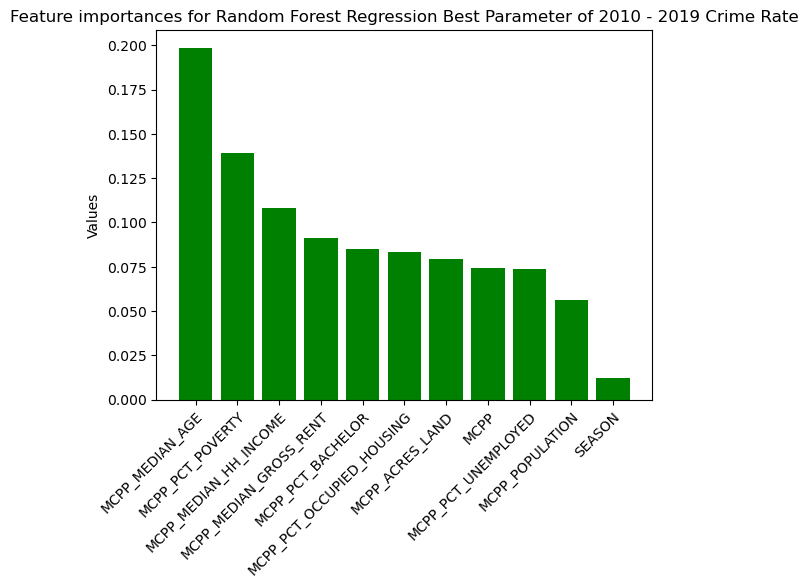

In [ ]:
plt.bar(x=rf_features_reg_gcv['FeatureNames'],
        height=rf_features_reg_gcv['Value'],
        color='green')
plt.title('Feature importances for Random Forest Regression Best Parameter of 2010 - 2019 Crime Rate')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.ylabel('Values')
plt.show()

#### Export Joblib

### RF conclusion

Interestingly, the feature importance changes but #1 feature is still median age!

Summary base RF:
* Random Forest, ALL data, Crime Rate regression, RMSE train: 9.6519
* Random Forest, ALL data, Crime Rate regression, RMSE train: 12.0119
* RF - ALL data, Crime Rate regression , train Rsquared: 0.9514
* RF- ALL data, Crime Rate regression, test Rsquared: 0.9315



Summary RandomizedCV:
* RandomForestRegressor(bootstrap=False, max_depth=36, max_features=1,
                      min_samples_leaf=3, min_samples_split=10,
                      n_estimators=50)
* Random Forest, Crime Rate regression, RMSE train: 9.6468
* Random Forest, Crime Rate regression, RMSE train: 12.0229
* RF - best RandomizedCV param , train R2: 0.9515
* RF - best RandomizedCV param, test R2: 0.9314


Summary GridSearchCV:
* RandomForestRegressor(bootstrap=False, max_depth=45, max_features=1,
                      min_samples_leaf=4, min_samples_split=8, n_estimators=40
* RF - best GridSearchCV param, Crime Rate regression, RMSE train: 9.6781
* RF - best GridSearchCV param, Crime Rate regression, RMSE train: 11.8796
* RF - best GridSearchCV param (14 features), train R2: 0.9512
* RF - best GridSearchCV param (14 features), test R2: 0.9330

Not much improvement!



## Gradient Boosting

### GB ALL data

In [ ]:
#create Gradient Boost Regression Model
    #since we have a lot of sample, n_elements might need to be increased
    # to cut down time, use the same  number of tree as RF to be consistent (100)
    # set learning rate (lr) as is since it is the same as the Lasso Regression optimum val.
    # lr is a more important hyperparameter.
gb_reg = ensemble.GradientBoostingRegressor(random_state=42)

#record the time
import time
start_time = time.time()

#fit the model (10% non standardized)
gb_reg.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.14380717277526855 seconds ---


In [ ]:
#record the time
import time
start_time = time.time()

#predict using the train dataset
y_pred_gb_tr = gb_reg.predict(X_train)
y_pred_gb = gb_reg.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.009647369384765625 seconds ---


In [ ]:
#get performance metrics for train dataset
#RMSE (squared=False returns rmse)
rmse_gb_tr = round(mean_squared_error(y_train, y_pred_gb_tr, squared=False),4)

#R2
r2_gb_tr = round(r2_score(y_train, y_pred_gb_tr), 4)

print('Gradient Boost, Original- Root Mean Squared error (RMSE):', rmse_gb_tr)
print('Gradient Boost,  Original - R-Squared:', r2_gb_tr)

#get performance metrics for test dataset
#RMSE (squared=False returns rmse)
rmse_gb = round(mean_squared_error(y_test, y_pred_gb, squared=False),4)

#R2
r2_gb = round(r2_score(y_test, y_pred_gb), 4)

print('Gradient Boost,  Original - Root Mean Squared error (RMSE):', rmse_gb)
print('Gradient Boost,  Original - R-Squared:', r2_gb)

Gradient Boost, Original- Root Mean Squared error (RMSE): 9.897
Gradient Boost,  Original - R-Squared: 0.9489
Gradient Boost,  Original - Root Mean Squared error (RMSE): 11.6278
Gradient Boost,  Original - R-Squared: 0.9358


In [ ]:
gb_features_reg = pd.DataFrame({'FeatureNames': gb_reg.feature_names_in_,
                            'Value': gb_reg.feature_importances_},
                           columns=['FeatureNames', 'Value'])
gb_features_reg = gb_features_reg.sort_values(by=['Value'], ascending=False)
gb_features_reg

,FeatureNames,Value
4,MCPP_MEDIAN_AGE,0.561214
5,MCPP_PCT_OCCUPIED_HOUSING,0.257556
8,MCPP_PCT_UNEMPLOYED,0.044983
9,MCPP_MEDIAN_HH_INCOME,0.028237
10,MCPP_PCT_POVERTY,0.026899
3,MCPP_ACRES_LAND,0.025358
2,MCPP_POPULATION,0.024159
6,MCPP_PCT_BACHELOR,0.016700
1,SEASON,0.005903
7,MCPP_MEDIAN_GROSS_RENT,0.004608


In [ ]:
# plt.bar(x=gb_features_reg['FeatureNames'], height=gb_features['count_GB'])
# plt.title('Feature importance for gb model - 10%')
# plt.xticks(rotation='vertical')
# plt.show()

Original GB:
* Gradient Boost, Original- Root Mean Squared error (RMSE): 9.897
* Gradient Boost,  Original - R-Squared: 0.9489
* Gradient Boost,  Original - Root Mean Squared error (RMSE): 11.6278
* Gradient Boost,  Original - R-Squared: 0.9358
* not overfitted, but population is too important. I thought they will increase the hard to predict?

### GridsearchCV

best param for randomizedCV:

{'n_estimators': 100,
 'min_samples_split': 6,
 'min_samples_leaf': 5,
 'max_depth': 100,
 'loss': 'squared_error',
 'learning_rate': 0.1}

randCV param:

{'n_estimators': [50, 100, 150, 200], 'loss': ['squared_error', 'huber'], 'max_depth': [10, 40, 70, 100, None], 'min_samples_split': [3, 6, 10], 'min_samples_leaf': [3, 5, 10], 'learning_rate': [0.01, 0.1, 0.3]}


base param:

*, loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0

In [ ]:
# List parameter grid based on the results of random search
param_grid_gb = {
    'max_depth': [3, 10, 50, 100],
    'min_samples_leaf': [2,5,7],
    'min_samples_split': [2, 4, 6, 7],
    'learning_rate': [0.005, 0.01, 0.1],
    'n_estimators': [75, 100, 120]
}

# Create a based model
reg_gb = ensemble.GradientBoostingRegressor(random_state=42)
gb_gridCV = GridSearchCV(estimator = reg_gb, param_grid = param_grid_gb,
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
#record the time
import time
start_time = time.time()

# Fit the grid search to the train dataset
gb_gridCV.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
--- 35.56537890434265 seconds ---


In [ ]:
gb_gridCV.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 120}

In [ ]:
gb_gridCV.best_estimator_

GradientBoostingRegressor(min_samples_leaf=5, n_estimators=120, random_state=42)

First run:

GradientBoostingRegressor(learning_rate=0.01, max_depth=90, min_samples_leaf=4,
                          min_samples_split=4, n_estimators=120)


Second run (change param):

GradientBoostingRegressor(min_samples_leaf=5, n_estimators=120)


Third run:

GradientBoostingRegressor(min_samples_leaf=5, n_estimators=120, random_state=42

In [ ]:
#compare with randomCV
gb_randCV.best_estimator_

GradientBoostingRegressor(max_depth=100, min_samples_leaf=5,
                          min_samples_split=6, random_state=42)

#### Best GridSearch CV model on full dataset

In [ ]:
#record the time
import time
start_time = time.time()

best_gridCV_gb = ensemble.GradientBoostingRegressor(**gb_gridCV.best_params_,
                                                    random_state=42)
best_gridCV_gb.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.1567845344543457 seconds ---


In [ ]:
y_pred_tr_reg_gcv_gb = best_gridCV_gb.predict(X_train)
y_pred_reg_gcv_gb = best_gridCV_gb.predict(X_test)

In [ ]:
#get performance metrics for train dataset
#RMSE (squared=False returns rmse)
rmse_gb_tr_reg_gcv = round(mean_squared_error(y_train, y_pred_tr_reg_gcv_gb, squared=False),4)

#get performance metrics for test dataset
rmse_gb_reg_gcv = round(mean_squared_error(y_test, y_pred_reg_gcv_gb, squared=False),4)

print('GB - best GridSearchCV param, Crime Rate regression, RMSE train:', rmse_gb_tr_reg_gcv)
print('GB - best GridSearchCV param, Crime Rate regression, RMSE train:', rmse_gb_reg_gcv)

#check R2
r2_gb_tr_reg_gcv = round(r2_score(y_train, y_pred_tr_reg_gcv_gb), 4)
r2_gb_reg_gcv = round(r2_score(y_test, y_pred_reg_gcv_gb), 4)

print('GB - best GridSearchCV param , train R2:', r2_gb_tr_reg_gcv)
print("GB - best GridSearchCV param, test R2: %.4f" % r2_gb_reg_gcv)

GB - best GridSearchCV param, Crime Rate regression, RMSE train: 9.8113
GB - best GridSearchCV param, Crime Rate regression, RMSE train: 11.6593
GB - best GridSearchCV param , train R2: 0.9498
GB - best GridSearchCV param, test R2: 0.9355


In [ ]:
crime_census_df["CRIME_RATE"].max()

401.85

In [ ]:
crime_census_df["CRIME_RATE"].min()

0.77

In [ ]:
gb_features_reg_gcv = pd.DataFrame({'FeatureNames': best_gridCV_gb.feature_names_in_,
                            'Value': best_gridCV_gb.feature_importances_},
                           columns=['FeatureNames', 'Value'])
gb_features_reg_gcv = gb_features_reg_gcv.sort_values(by=['Value'], ascending=False)
gb_features_reg_gcv

,FeatureNames,Value
4,MCPP_MEDIAN_AGE,0.560834
5,MCPP_PCT_OCCUPIED_HOUSING,0.257332
8,MCPP_PCT_UNEMPLOYED,0.044958
9,MCPP_MEDIAN_HH_INCOME,0.028403
10,MCPP_PCT_POVERTY,0.026901
3,MCPP_ACRES_LAND,0.025389
2,MCPP_POPULATION,0.024249
6,MCPP_PCT_BACHELOR,0.016706
1,SEASON,0.006186
7,MCPP_MEDIAN_GROSS_RENT,0.004655


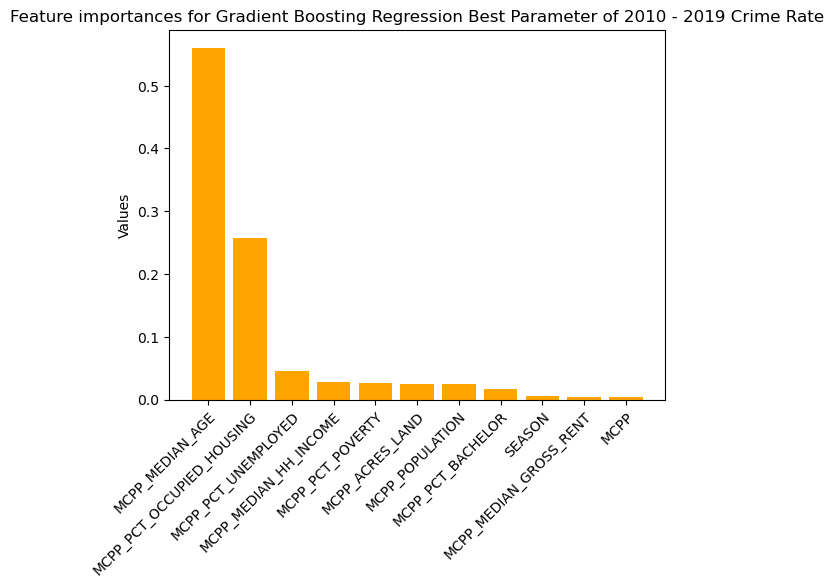

In [ ]:
plt.bar(x=gb_features_reg_gcv['FeatureNames'],
        height=gb_features_reg_gcv['Value'],
        color='orange')
plt.title('Feature importances for Gradient Boosting Regression Best Parameter of 2010 - 2019 Crime Rate')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.ylabel('Values')
plt.show()

## KNN model

base model:

KNeighborsRegressor(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

In [ ]:
#record the time
import time
start_time = time.time()

#fit the model
  #set all parameters as standard first
KNNmodel = KNeighborsRegressor() #p=2 is eucledian distance, p=1 is manhattan
KNNmodel.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0 seconds ---


In [ ]:
#record the time
import time
start_time = time.time()

#predict
y_pred_tr_knn = KNNmodel.predict(X_train)

#predict test data
y_pred_knn = KNNmodel.predict(X_test)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.013296842575073242 seconds ---


In [ ]:
#RMSE (squared=False returns rmse)
rmse_knn_tr = round(mean_squared_error(y_train, y_pred_tr_knn, squared=False),4)
#R2
r2_knn_tr = round(r2_score(y_train, y_pred_tr_knn), 4)
print('KNN (base), train - Root Mean Squared Error (RMSE):', rmse_knn_tr)
print('KNN (base), train - R-Squared:', r2_knn_tr)

#RMSE (squared=False returns rmse)
rmse_knn = round(mean_squared_error(y_test, y_pred_knn, squared=False),4)
#R2
r2_knn = round(r2_score(y_test, y_pred_knn), 4)
print('KNN (base), test - Root Mean Squared Error (RMSE):', rmse_knn)
print('KNN (base), test - R-Squared:', r2_knn)

KNN (base), train - Root Mean Squared Error (RMSE): 10.0738
KNN (base), train - R-Squared: 0.9471
KNN (base), test - Root Mean Squared Error (RMSE): 12.5542
KNN (base), test - R-Squared: 0.9252


In [ ]:
# define performance metrics
from sklearn.metrics import mean_squared_error, r2_score

def performance_matrix_reg(y_train, y_pred_train, y_test, y_pred_test, **description):
    "calculate rmse and r-squared for regression model"
    rmse_train = round(mean_squared_error(y_train, y_pred_train, squared=False),4)
    rmse_test = round(mean_squared_error(y_test, y_pred_test, squared=False),4)

    print("RMSE for ", description, "train: ", rmse_train, " and test: ", rmse_test)

    r2_train = round(r2_score(y_train, y_pred_train), 4)
    r2_test = round(r2_score(y_test, y_pred), 4)
    print("R-squared for ", description, "train: ", r2_train, " and test: ", r2_test)

    return rmse_train, rmse_test, r2_train, r2_test

### KNN cross-validation to find best K

### GridSearchCV

base model:

KNeighborsRegressor(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

In [ ]:
# List parameter grid based on the results of random search
param_grid_knn = {
    'n_neighbors': list(range(1, 16)), #total is 2000 samples, so max is 1%?
    'weights': ["uniform",  "distance"],
    'p': [1,2]
}

# Create a based model
reg_knn = KNeighborsRegressor()
knn_gridCV = GridSearchCV(estimator = reg_knn, param_grid = param_grid_knn,
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
#record the time
import time
start_time = time.time()

# Fit the grid search to the train dataset
knn_gridCV.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 3 folds for each of 60 candidates, totalling 180 fits
--- 1.9780573844909668 seconds ---


In [ ]:
knn_gridCV.best_params_

{'n_neighbors': 6, 'p': 2, 'weights': 'uniform'}

In [ ]:
knn_gridCV.best_estimator_

KNeighborsRegressor(n_neighbors=6)

#### Best GridSearch CV model on full dataset

In [ ]:
#record the time
import time
start_time = time.time()

best_gridCV_knn = KNeighborsRegressor(**knn_gridCV.best_params_)
best_gridCV_knn.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.012415647506713867 seconds ---


In [ ]:
y_pred_tr_reg_gcv_knn = best_gridCV_knn.predict(X_train)
y_pred_reg_gcv_knn = best_gridCV_knn.predict(X_test)

In [ ]:
#get performance metrics for train dataset
#RMSE (squared=False returns rmse)
rmse_knn_tr_reg_gcv = round(mean_squared_error(y_train, y_pred_tr_reg_gcv_knn, squared=False),4)

#get performance metrics for test dataset
rmse_knn_reg_gcv = round(mean_squared_error(y_test, y_pred_reg_gcv_knn, squared=False),4)

print('knn- best GridSearchCV param, Crime Rate regression, RMSE train:', rmse_knn_tr_reg_gcv)
print('knn - best GridSearchCV param, Crime Rate regression, RMSE train:', rmse_knn_reg_gcv)

#check R2
r2_knn_tr_reg_gcv = round(r2_score(y_train, y_pred_tr_reg_gcv_knn), 4)
r2_knn_reg_gcv = round(r2_score(y_test, y_pred_reg_gcv_knn), 4)

print('knn - best GridSearchCV param , train R2:', r2_knn_tr_reg_gcv)
print("knn - best GridSearchCV param, test R2: %.4f" % r2_knn_reg_gcv)

knn- best GridSearchCV param, Crime Rate regression, RMSE train: 9.7411
knn - best GridSearchCV param, Crime Rate regression, RMSE train: 12.0372
knn - best GridSearchCV param , train R2: 0.9505
knn - best GridSearchCV param, test R2: 0.9312


In [ ]:
crime_census_df["CRIME_RATE"].max()

401.85

In [ ]:
crime_census_df["CRIME_RATE"].min()

0.77

### KNN conclusion

pretty high R2 already, and comparable RMSE!


## Summary of Models' Performance Metrics

In [ ]:
#summary of all metrics:

df_metrics_CR = pd.DataFrame(np.array([
        ['Linear Regression', rmse_linear_tr, rmse_linear, r2_linear_tr, r2_linear, 0.0097],
        ['Lasso Regression', rmse_lasso_tr, rmse_lasso, r2_lasso_tr, r2_lasso, 0.006],
        #['Lasso Regression (10%)', rmse_lasso10_tr, rmse_lasso10, r2_lasso10_tr, r2_lasso10, 0.806],
        #['Decision Tree - DT (10%)', rmse_dt_tr, rmse_dt, r2_dt_tr, r2_dt, 287.21],
        ['Random Forest - RF (base)', rmse_rf_tr_reg, rmse_rf_reg, r2_rf_tr_reg, r2_rf_reg, 0.3784],
        ['Random Forest - RF (best)', rmse_rf_tr_reg_gcv, rmse_rf_reg_gcv, r2_rf_tr_reg_gcv, r2_rf_reg_gcv, 0.0470],
        ['Gradient Boost - GB (base)', rmse_gb_tr, rmse_gb, r2_gb_tr, r2_gb,  0.1438],
        ['Gradient Boost - GB (best)', rmse_gb_tr_reg_gcv, rmse_gb_reg_gcv, r2_gb_tr_reg_gcv, r2_gb_reg_gcv, 0.1567],
        ['K-Nearest Neighbor -KNN (k=5, base)', rmse_knn_tr, rmse_knn, r2_knn_tr, r2_knn, 0.0132],
        ['K-Nearest Neighbor -KNN (k=6, best)', rmse_knn_tr_reg_gcv, rmse_knn_reg_gcv,
         r2_knn_tr_reg_gcv, r2_knn_reg_gcv, 0.0124],
        ['MLP Neural Network - (base)', rmse_NN_tr, rmse_NN, r2_NN_tr, r2_NN,  0.7555],
        ['MLP Neural Network - (best)', rmse_NN_tr_reg_gcv, rmse_NN_reg_gcv, r2_NN_tr_reg_gcv, r2_NN_reg_gcv, 0.8333]
        ]),
        columns=['Regression Model', 'RMSE (train)', 'RMSE (test)', '$R^2$ (train)',
             '$R^2$ (test)', 'computation time (sec)'])
print('Performance metrics for Crime Rate Regression on Seattle Police Department 2010-2019 dataset')
df_metrics_CR

Performance metrics for Crime Rate Regression on Seattle Police Department 2010-2019 dataset


,Regression Model,RMSE (train),RMSE (test),$R^2$ (train),$R^2$ (test),computation time (sec)
0,Linear Regression,26.4161,28.2948,0.6361,0.6199,0.0097
1,Lasso Regression,26.4414,28.3675,0.6354,0.618,0.006
2,Random Forest - RF (base),9.6519,12.0119,0.9514,0.9315,0.3784
3,Random Forest - RF (best),9.6781,11.8796,0.9512,0.933,0.047
4,Gradient Boost - GB (base),9.897,11.6278,0.9489,0.9358,0.1438
5,Gradient Boost - GB (best),9.8113,11.6593,0.9498,0.9355,0.1567
6,"K-Nearest Neighbor -KNN (k=5, base)",10.0738,12.5542,0.9471,0.9252,0.0132
7,"K-Nearest Neighbor -KNN (k=6, best)",9.7411,12.0372,0.9505,0.9312,0.0124
8,MLP Neural Network - (base),26.3303,26.5052,0.6384,0.6665,0.7555
9,MLP Neural Network - (best),16.1828,17.0855,0.8634,0.8614,0.8333


In [ ]:
df_metrics_CR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Regression Model        10 non-null     object
 1   RMSE (train)            10 non-null     object
 2   RMSE (test)             10 non-null     object
 3   $R^2$ (train)           10 non-null     object
 4   $R^2$ (test)            10 non-null     object
 5   computation time (sec)  10 non-null     object
dtypes: object(6)
memory usage: 608.0+ bytes


In [ ]:
cols = df_metrics_CR.columns.drop('Regression Model')

df_metrics_CR[cols] = df_metrics_CR[cols].apply(pd.to_numeric, errors='coerce')
df_metrics_CR

,Regression Model,RMSE (train),RMSE (test),$R^2$ (train),$R^2$ (test),computation time (sec)
0,Linear Regression,26.4161,28.2948,0.6361,0.6199,0.0097
1,Lasso Regression,26.4414,28.3675,0.6354,0.6180,0.0060
2,Random Forest - RF (base),9.6519,12.0119,0.9514,0.9315,0.3784
3,Random Forest - RF (best),9.6781,11.8796,0.9512,0.9330,0.0470
4,Gradient Boost - GB (base),9.8970,11.6278,0.9489,0.9358,0.1438
5,Gradient Boost - GB (best),9.8113,11.6593,0.9498,0.9355,0.1567
6,"K-Nearest Neighbor -KNN (k=5, base)",10.0738,12.5542,0.9471,0.9252,0.0132
7,"K-Nearest Neighbor -KNN (k=6, best)",9.7411,12.0372,0.9505,0.9312,0.0124
8,MLP Neural Network - (base),26.3303,26.5052,0.6384,0.6665,0.7555
9,MLP Neural Network - (best),16.1828,17.0855,0.8634,0.8614,0.8333
